# Импорт библиотек

In [49]:
# based on https://www.kaggle.com/konstanter/fasterrcnn-pytorch-maskdetection

import numpy as np 
import pandas as pd 
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import xml.etree.ElementTree as et
import cv2
import os
import glob

# Загрузка данных в DataLoader

In [54]:
# путь к файлам
images_dir = 'C:/Users/user/Downloads/Masks/Images/'
annotations_dir = 'C:/Users/user/Downloads/Masks/annotations/'


class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        
        # сортировка изображений
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        
        # на 0й позиции находится фон
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0
        
        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # высота и ширина изобрадения
        wt = img.shape[1]
        ht = img.shape[0]
        
        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# проверка датасета
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target = dataset[78]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[113.1163, 146.7200, 163.7209, 205.5200]]), 'labels': tensor([2]), 'area': tensor([2975.5537]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


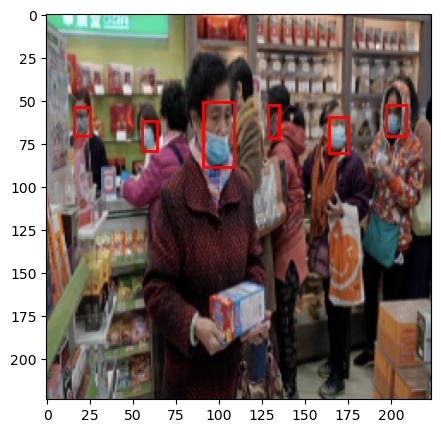

In [55]:
# Вспомогательная функция для визуализации bbox

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Отрисуем bbox поверх картинки
        a.add_patch(rect)
    plt.show()
    
img, target = dataset[35]
plot_img_bbox(img, target)

In [56]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            #A.HorizontalFlip(0.5),
                            #A.RandomBrightnessContrast(p=0.2),
                            #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [57]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [58]:
def get_transform(train):
    if train:
        return A.Compose([
                            ToTensorV2(p=1.0) 
                        ])
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ])

In [59]:
def get_transform(train):
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                            A.RandomBrightnessContrast(p=0.2),
                            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [60]:
dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=False))

# разделим данные на train и test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# Обучение модели

In [61]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [67]:
if __name__ == "__main__":
    # Путь к директориям с изображениями и аннотациями
    images_dir = 'C:/Users/user/Downloads/Masks/Images/'
    annotations_dir = 'C:/Users/user/Downloads/Masks/annotations/'

    # Создание экземпляров датасетов
    dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480)
    dataset_test = FaceMaskDataset(images_dir, annotations_dir, 480, 480)

    # Разделение данных на train и test
    torch.manual_seed(1)
    indices = torch.randperm(len(dataset)).tolist()
    test_split = 0.2
    tsize = int(len(dataset) * test_split)
    dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=10, shuffle=True, num_workers=0,
        collate_fn=lambda x: tuple(zip(*x))
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=10, shuffle=False, num_workers=0,
        collate_fn=lambda x: tuple(zip(*x))
    )

    # Установка устройства
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    num_classes = 4  # Число классов
    model = get_model_instance_segmentation(num_classes)
    model.to(device)

    num_epochs = 5  # Количество эпох
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for imgs, annotations in data_loader:
            imgs = list(img.to(device) for img in imgs)  # Переносим тензоры на устройство
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())        

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()         
            epoch_loss += losses.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print("Training complete!")

Loaded 853 images and 853 annotations
Loaded 853 images and 853 annotations
Epoch 1/5, Loss: 35.6533
Epoch 2/5, Loss: 22.5294
Epoch 3/5, Loss: 18.3857
Epoch 4/5, Loss: 16.3974
Epoch 5/5, Loss: 14.7550
Training complete!


# Сохраним модель

In [68]:
torch.save(model.state_dict(), 'model_face_mask.pth')

In [69]:
# вспомогательная функция принимает исходный прогноз и порог iou

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

In [70]:
img, target = dataset_test[4]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  3
real #boxes:  1


EXPECTED OUTPUT


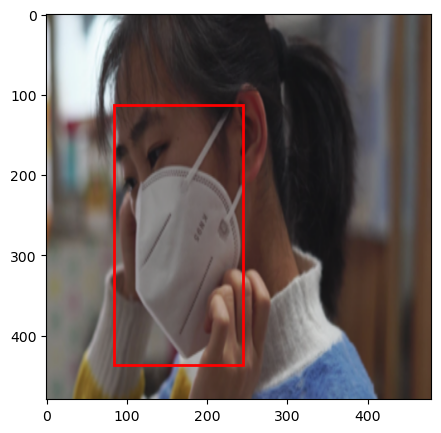

In [74]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


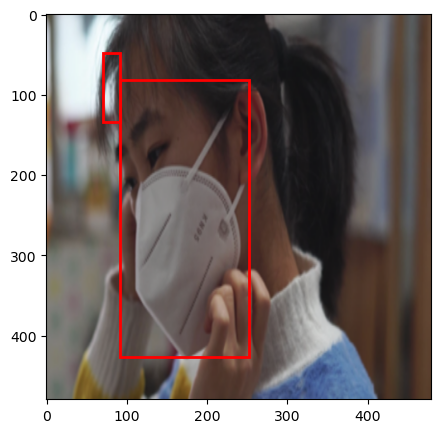

In [77]:
# Предполагая, что `img` - это изображение, а `prediction` - предсказания модели
img_cpu = img.cpu()  # Переносим изображение на CPU
img_pil = torch_to_pil(img_cpu)  # Преобразуем тензор в PIL Image

# Убедитесь, что предсказания тоже на CPU
prediction_cpu = {k: v.cpu() for k, v in prediction.items()}

# Визуализация
print('MODEL OUTPUT')
plot_img_bbox(img_pil, prediction_cpu)

NMS APPLIED MODEL OUTPUT


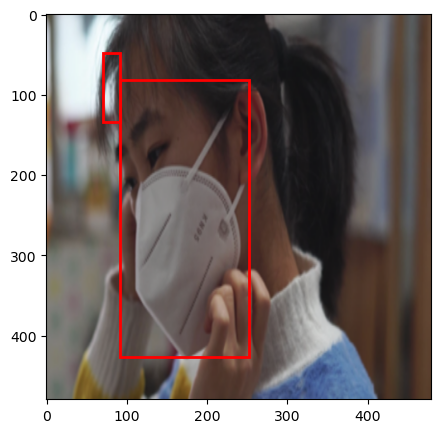

In [79]:
# Предполагая, что `img` - это изображение, а `nms_prediction` - предсказания модели
# Переносим изображение на CPU
img_cpu = img.cpu()  # Если img - это тензор
img_pil = torch_to_pil(img_cpu)  # Преобразуем тензор в PIL Image

# Убедитесь, что предсказания тоже на CPU
nms_prediction_cpu = {k: v.cpu() for k, v in nms_prediction.items()}

# Визуализация с применением NMS
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(img_pil, nms_prediction_cpu)

NMS APPLIED MODEL OUTPUT


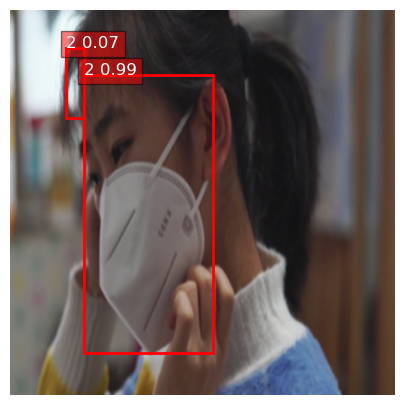

In [94]:
# Убедимся, что перед вызовом plot_img_bbox мы перевели все тензоры на CPU
nms_prediction_cpu = {
    'boxes': nms_prediction['boxes'].cpu().detach().numpy(),
    'scores': nms_prediction['scores'].cpu().detach().numpy(),
    'labels': nms_prediction['labels'].cpu().detach().numpy()
}

# Визуализация с применением NMS
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(img_pil, nms_prediction_cpu)

# Отрисовка изображений

In [108]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image(img_tensor, annotation, predict=True):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(18.5, 10.5)
    img = img_tensor.cpu().data
    mask_dic = {1: 'without_mask', 2: 'with_mask', 3: 'mask_weared_incorrect'}

    ax.imshow(img.permute(1, 2, 0))

    for i, box in enumerate(annotation["boxes"]):
        # Используем detach(), чтобы избежать ошибки
        xmin, ymin, xmax, ymax = box.detach().cpu().numpy()

        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin),
                                 linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)
        label = mask_dic[int(annotation['labels'][i].data)]
        if predict:
            score = int((annotation['scores'][i].data) * 100)
            ax.text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center',
                    verticalalignment='center', fontsize=20, color='b')
        else:
            ax.text(xmin, ymin, f"{label}", horizontalalignment='center',
                    verticalalignment='center', fontsize=20, color='b')
    plt.show()

In [109]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [110]:
model.eval()
preds = model(imgs)

Prediction


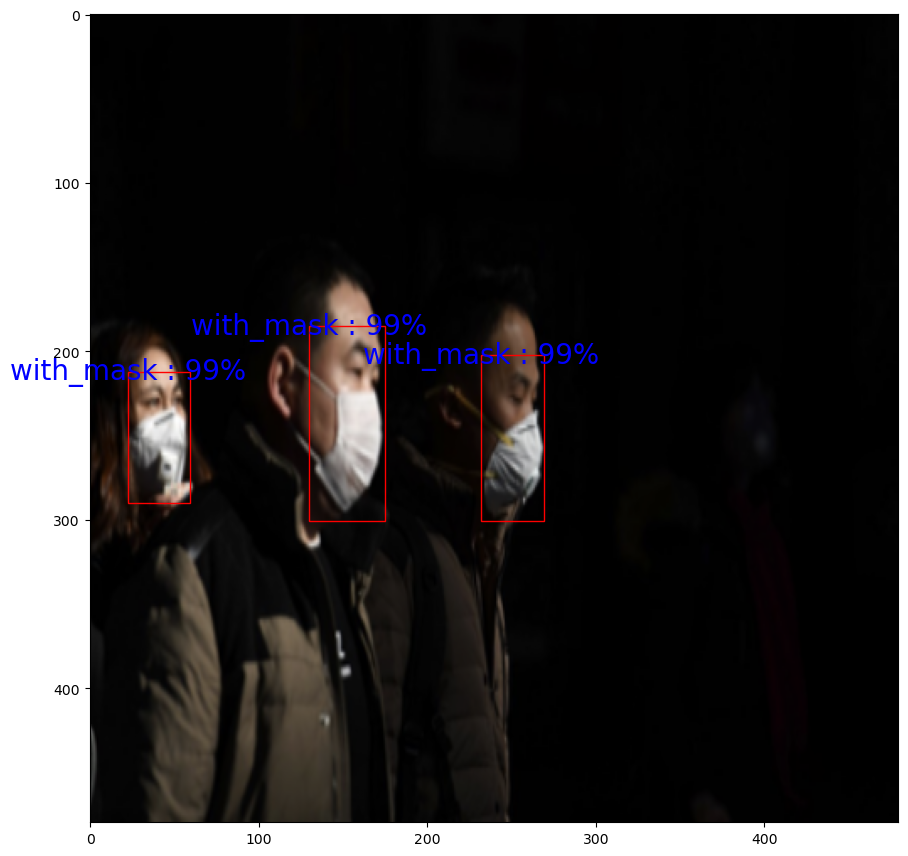

Target


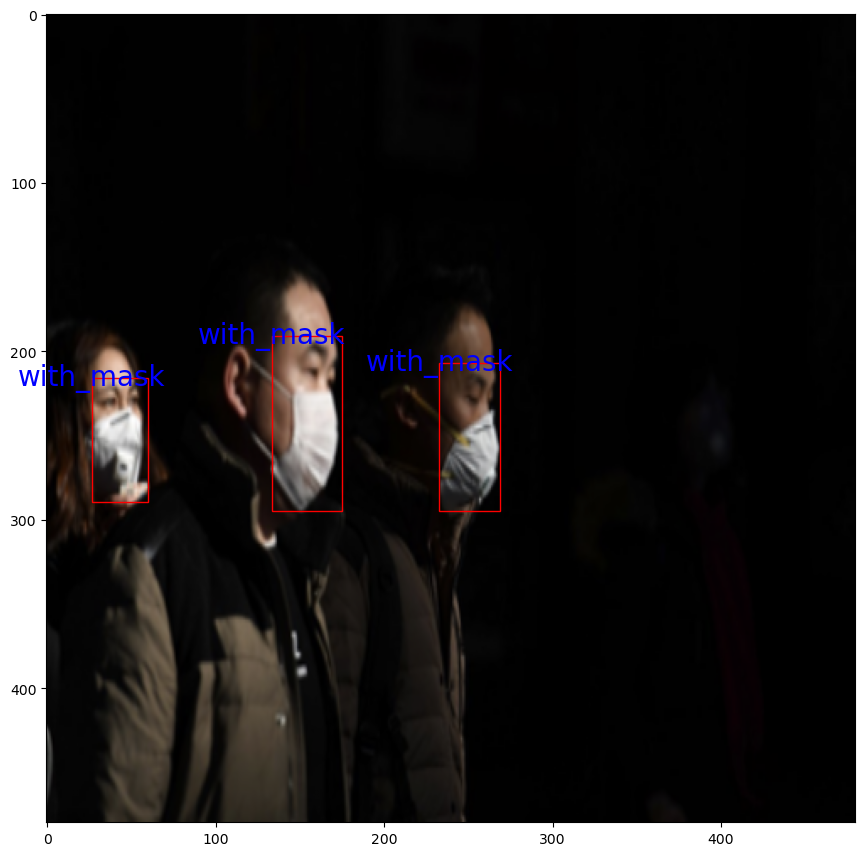

In [111]:
nms_prediction = apply_nms(preds[7], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[7], nms_prediction)
print("Target")
plot_image(imgs[7].to('cpu'), annotations[7],False)

Prediction


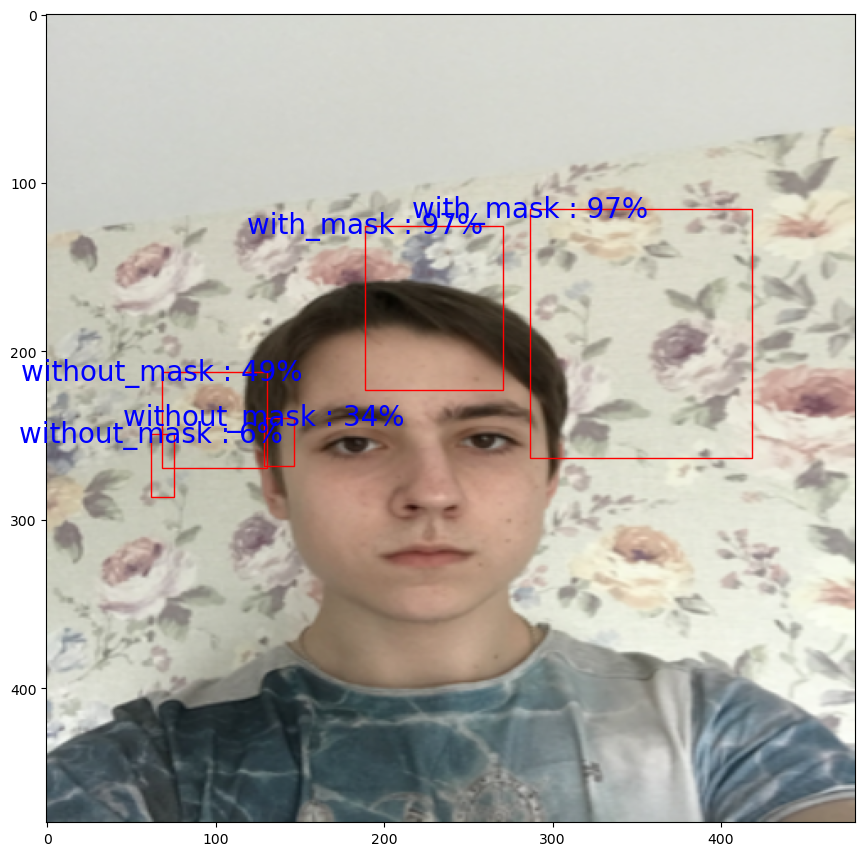

Target


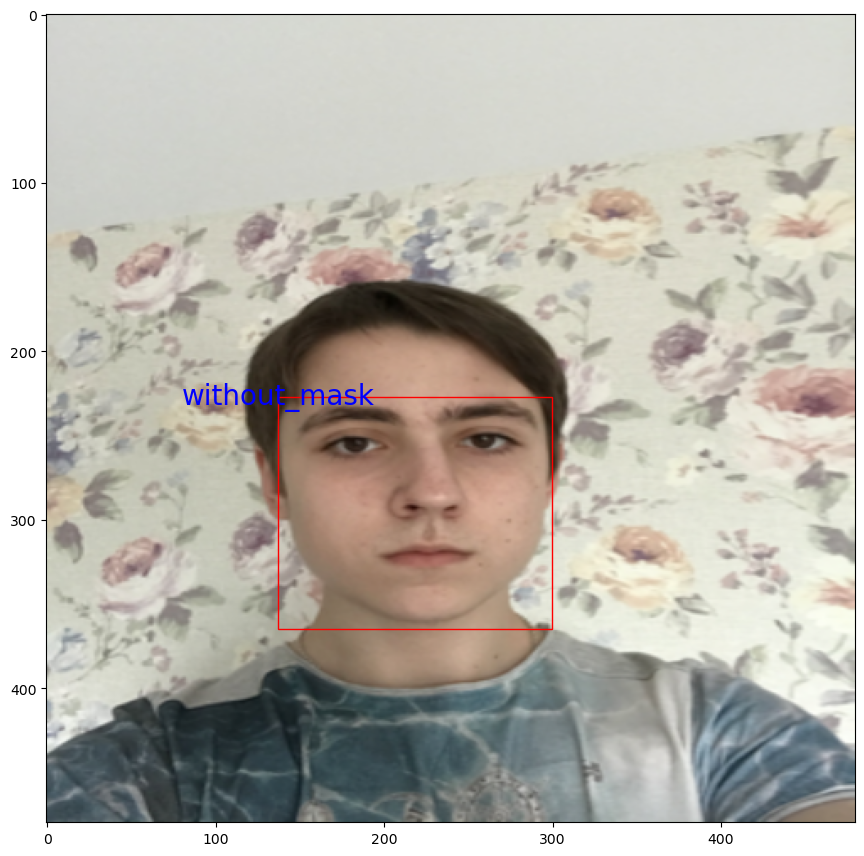

In [106]:
nms_prediction = apply_nms(preds[0], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[0], nms_prediction)
print("Target")
plot_image(imgs[0].to('cpu'), annotations[0],False)

Prediction


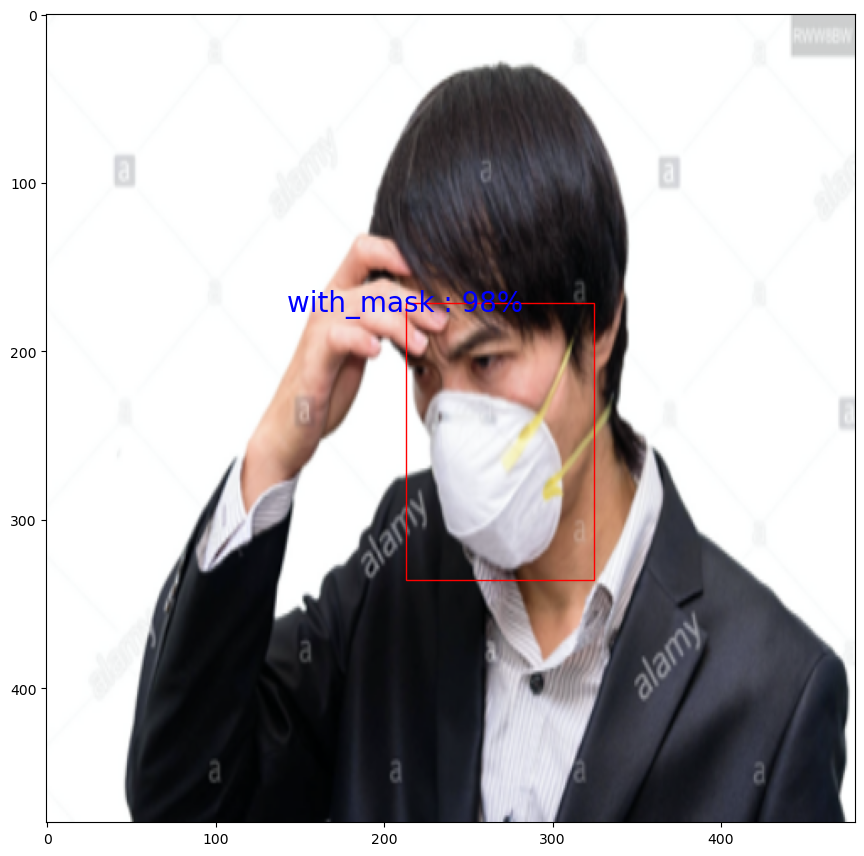

Target


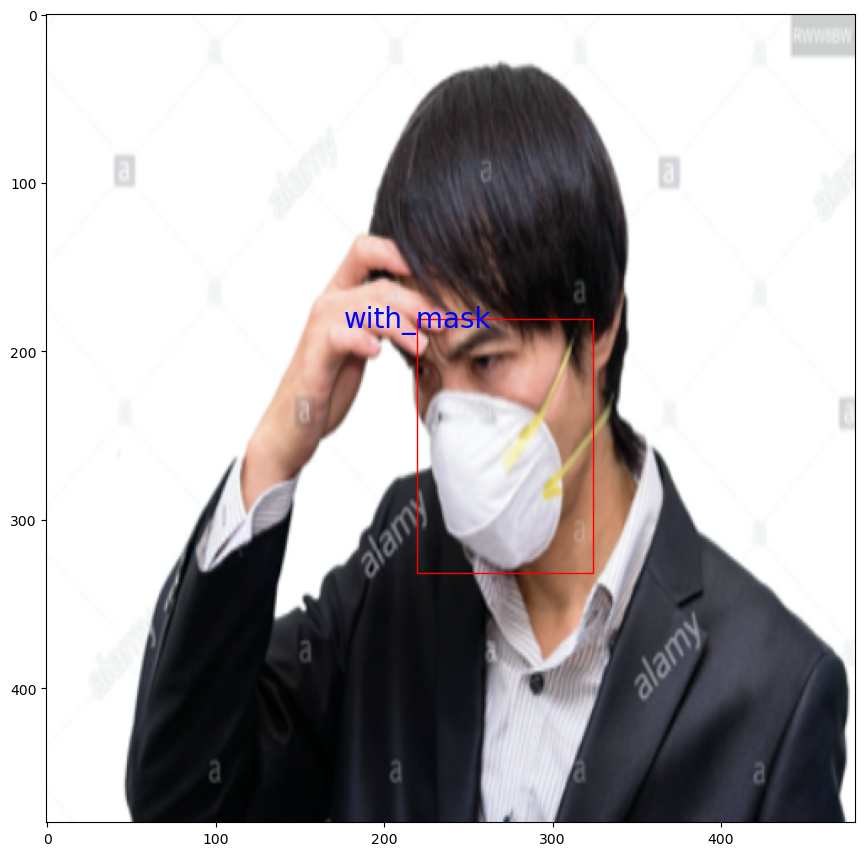

In [112]:
nms_prediction = apply_nms(preds[2], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[2], nms_prediction)
print("Target")
plot_image(imgs[2].to('cpu'), annotations[2],False)